In [ ]:
#references : https://www.youtube.com/watch?v=kMJDsh0TCik&ab_channel=ManusiaSetengahChiKuadrat

In [1]:
import pandas as pd
import numpy as np
import re
import string

# Read Data

In [2]:
review_nlp = pd.read_csv('./review tokped mentah.csv')
review_nlp.head()

,content,score
0,keren,5
1,sukses untuk GOTO,5
2,Kenapa tidak bisa top up,1
3,"Saya beli hp di sini baru ini begini, reseller...",1
4,good job,5


In [3]:
review_nlp['score'].value_counts()

5    122
1     45
4     13
2     10
3     10
Name: score, dtype: int64

# Labeling

In [4]:
label = []

for index, row in review_nlp.iterrows():
    if row['score'] >=4 : 
        label.append(1) #label 1 untuk rating 4 keatas
    else : 
        label.append(0) #label 0 untuk rating 3 sampai 1
        
review_nlp['label'] = label
review_nlp = review_nlp.drop(columns=['score'])

review_nlp.head()

,content,label
0,keren,1
1,sukses untuk GOTO,1
2,Kenapa tidak bisa top up,0
3,"Saya beli hp di sini baru ini begini, reseller...",0
4,good job,1


In [5]:
review_nlp['label'].value_counts()

1    135
0     65
Name: label, dtype: int64

# mengatasi data tidak imbang

In [6]:
#oversampling
s1 = review_nlp[review_nlp['label']==1].sample(130, replace=True)
s2 = review_nlp[review_nlp['label']==0].sample(130, replace=True)
review_nlp = pd.concat([s1,s2])
print(review_nlp.shape)
print(review_nlp['label'].value_counts(normalize=True))

(260, 2)
1    0.5
0    0.5
Name: label, dtype: float64


# visualisasi text

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

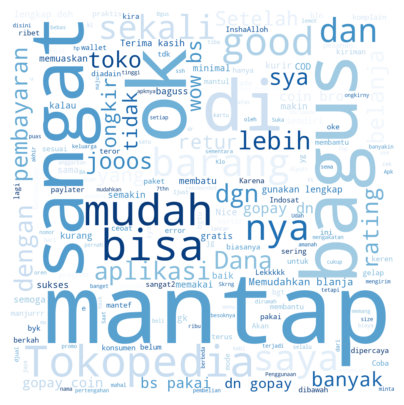

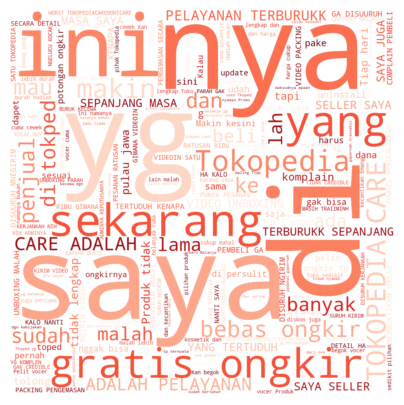

In [8]:
content_1 = review_nlp[review_nlp['label']==1]
content_1 = ' '.join(word for word in content_1['content'])
wcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode= 'RGBA', background_color='white').generate(content_1)
plt.figure(figsize=(5, 5))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

content_0 = review_nlp[review_nlp['label']==0]
content_0 = ' '.join(word for word in content_0['content'])
wcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode= 'RGBA', background_color='white').generate(content_0)
plt.figure(figsize=(5, 5))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

# Text Cleansing

In [9]:
def remove_unused(text):
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'@[\w]*', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = text.replace('\n', ' ')
    text = text.encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    text = re.sub(r'[^\w]', ' ', text)
    space = ['    ', '   ', '  ']
    for i in space:
        text = text.replace(i, ' ')
    text = text.lower().strip()
#     text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [10]:
review_nlp['clean text'] = review_nlp['content'].apply(lambda x: remove_unused(x))
review_nlp = review_nlp[['clean text', 'label']]

In [11]:
review_nlp

,clean text,label
140,udah thn selalu belanja di tokopedia terima ka...,1
158,mantap,1
70,ok,1
0,keren,1
19,ok,1
...,...,...
45,selsaikan kasus genteng baru saya tambah binta...,0
60,tokopedia care adalah pelayanan terburukk sepa...,0
73,coba coba,0
14,banyak yang nggak bisa cod tolong diperbaiki,0


In [12]:
#import stemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem import PorterStemmer
stemmer_e = PorterStemmer()
stemmer = StemmerFactory().create_stemmer()

In [13]:
#import stopword
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords
stopworder = set(stopwords.words('indonesian', 'english'))
stopword = StopWordRemoverFactory().create_stop_word_remover()

In [14]:
def cleansing(data):
    stemm_id = stemmer.stem(data) #stemmer indo
    stemm_en = stemmer_e.stem(stemm_id) #stemmer inggris
    stopwording_id = stopword.remove(stemm_en)
    stopwording_en = [word for word in [stopwording_id] if word not in stopworder]
    text = ' '.join(word for word in stopwording_en)
    return text

In [15]:
#contoh
tes ='jika novel berteriak minta keadilan bagaimana'
cleaned = cleansing(tes)
print(cleaned)

novel teriak adil


In [16]:
data_clean = review_nlp['clean text'].apply(cleansing)

In [17]:
data_clean

140    udah thn belanja tokopedia terima kasih tokope...
158                                               mantap
70                                                    ok
0                                                  keren
19                                                    ok
                             ...                        
45                             selsaikan genteng bintang
60     tokopedia care layan terburukk seller tuduh bu...
73                                             coba coba
14                                      nggak cod tolong
147    tokopedia gimana sih batalin pesananseenaknya ...
Name: clean text, Length: 260, dtype: object

In [18]:
review_nlp['text'] = data_clean
data_nlp = review_nlp[['text', 'label']]

In [19]:
data_nlp.head()

,text,label
140,udah thn belanja tokopedia terima kasih tokope...,1
158,mantap,1
70,ok,1
0,keren,1
19,ok,1


# Feature Enginering Bag Of Word

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
vectorizer_bow= CountVectorizer()

In [22]:
chat = ['halo apa kabar', 
        'selamat bulan puasa',
        'lagi dimana',
        'how dinner eat'
       ]
chet = ['haha apa kabar', 
        'selam bulan puasa',
        'lagi mana',
        'horse eat'
       ]

In [23]:
vectorized_bow = vectorizer_bow.fit_transform(chat)

In [24]:
vectorized_bow.shape

(4, 11)

In [25]:
#contoh feature
print(vectorized_bow.todense())

[[1 0 0 0 0 1 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 1]
 [0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 1 0 1 0 0 0 0]]


In [26]:
vectorizer_bow.get_feature_names()

C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['apa',
 'bulan',
 'dimana',
 'dinner',
 'eat',
 'halo',
 'how',
 'kabar',
 'lagi',
 'puasa',
 'selamat']

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(review_nlp['text'], review_nlp['label'], test_size=0.1,
                                                  stratify = review_nlp['label'], random_state=30)

In [28]:
X_train = vectorizer_bow.fit_transform(X_train) 
X_test = vectorizer_bow.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(234, 514)
(26, 514)


# Modeling

In [29]:
from sklearn import svm
svm_clf = svm.SVC(kernel='linear')

In [30]:
svm_clf.fit(X_train, y_train)

SVC(kernel='linear')

In [31]:
pred = svm_clf.predict(X_test)

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [33]:
accuracy = accuracy_score(y_test, pred)
print(f'accuracy : {accuracy}')

accuracy : 0.9230769230769231


In [34]:
clf_r = classification_report(y_test, pred)
print(clf_r)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.92      0.92      0.92        13

    accuracy                           0.92        26
   macro avg       0.92      0.92      0.92        26
weighted avg       0.92      0.92      0.92        26



C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


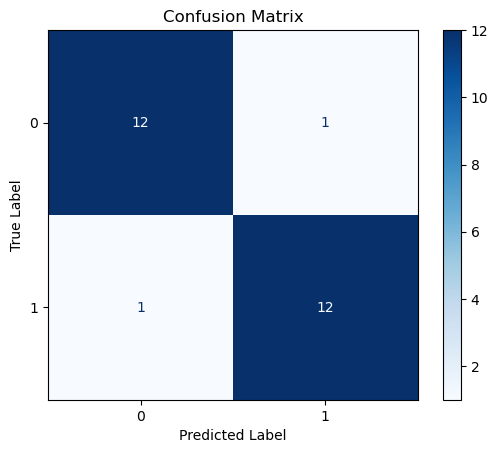

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
 
color = 'black'
matrix = plot_confusion_matrix(svm_clf, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [36]:
import pickle

In [37]:
pickle.dump(svm_clf,open('model_svm_bow.pkl', 'wb'))

# Prediksi

In [38]:
label = {1 : 'good', 0 : 'bad'}
print(label)

{1: 'good', 0: 'bad'}


In [39]:
textb = 'sangat bagus, aplikasi mudah membantu, suka berguna'
textj = 'susah jelek, tidak berguna, buruk kecewa, sulit dipakai lambat banyak iklan'

# Cleansing

In [40]:
text_clean = remove_unused(textj)
print(text_clean)
text_clean = cleansing(text_clean)
print(text_clean)

susah jelek tidak berguna buruk kecewa sulit dipakai lambat banyak iklan
susah jelek buruk kecewa sulit pakai lambat iklan


# to numeric

In [41]:
pred_text = vectorizer_bow.transform([text_clean])
print(pred_text.shape)
print(pred_text.todense())

(1, 514)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [42]:
prediksi = svm_clf.predict(pred_text)
i = np.max(prediksi)
lab = label[i]
hasil = (f'merupakan text : {lab}')
print(hasil)

merupakan text : bad


# Model Naive Bayes

In [43]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [44]:
X_traind = X_train.toarray()
X_testd = X_test.toarray()

print(X_traind.shape)
print(X_testd.shape)

(234, 514)
(26, 514)


In [45]:
gnb.fit(X_traind, y_train)
predgnb = gnb.predict(X_testd)

In [46]:
accuracy = accuracy_score(y_test, predgnb)
print(f'accuracy : {accuracy}')

accuracy : 0.8846153846153846


In [47]:
clf_r = classification_report(y_test, predgnb)
print(clf_r)

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        13
           1       1.00      0.77      0.87        13

    accuracy                           0.88        26
   macro avg       0.91      0.88      0.88        26
weighted avg       0.91      0.88      0.88        26



C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


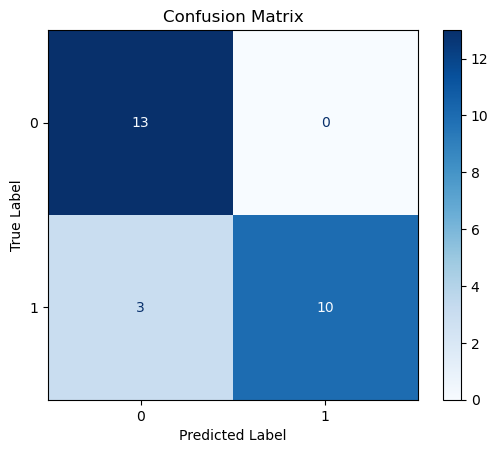

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
 
color = 'black'
matrix = plot_confusion_matrix(gnb, X_testd, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [49]:
pickle.dump(gnb,open('model_GNaiveBayes_bow.pkl', 'wb'))

In [50]:
prediksi = gnb.predict(pred_text.toarray())
i = np.max(prediksi)
lab = label[i]
hasil = (f'merupakan text : {lab}')
print(hasil)

merupakan text : bad
